In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
from util import delay_embed, lift_function

In [4]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data and CVs 

In [5]:
livac_trajs = np.load(
    "../../data/sb_ind100_TICA/livac_trajs_anton.npy", allow_pickle=True
)
ri_trajs = np.load("../../data/raw_feat/ri126_dist_anton.npz.npy", allow_pickle=True)
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [8]:
data_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)

In [9]:
print(len(livac_trajs), len(ri_trajs), len(data_trajs), len(cv_trajs))

livac_arr = np.concatenate(livac_trajs)
ri_arr = np.concatenate(ri_trajs)
data_arr = np.concatenate(data_trajs)
cv_arr = np.concatenate(cv_trajs)
print(livac_arr.shape, ri_arr.shape, data_arr.shape, cv_arr.shape)

237 237 237 237
(3000000, 5) (3000000, 5) (3000000, 60) (3000000, 2)


In [10]:
ivac_trajs = np.load("../../data/feat2_anton_ivac.npy", allow_pickle=True)
ivac_arr = np.concatenate(ivac_trajs)
print(len(ivac_trajs), ivac_trajs[0].shape)
print(ivac_arr.shape)

237 (10000, 10)
(3000000, 10)


# Delay embed salt bridge + CVs

In [11]:
n_embed = 10
lag = 20
# use smaller input feature set
# R223-D129, R226-D129, R226-D186, R229-D129, R229-D186, R232-D186
sb_ids = [36, 42, 47, 48, 53, 59]
data_orig = [
    np.hstack((cv_traj, traj[:, sb_ids]))
    for (cv_traj, traj) in zip(cv_trajs, data_trajs)
]
embed_trajs = delay_embed(data_orig, n_embed, lag)
embed_arr = np.concatenate(embed_trajs)

In [12]:
data_orig[0].shape

(10000, 8)

In [13]:
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

237 (9800, 88)
(2952600, 88)


In [14]:
orig_traj_lens = [len(traj) for traj in livac_trajs]
orig_traj_inds = []
subtot = 0
for length in orig_traj_lens[:-1]:
    subtot += length
    orig_traj_inds.append(subtot)

In [15]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
tic2 = livac_arr[:, 2]
sb5 = data_arr[:, 47]  # R2-D186
sb6 = data_arr[:, 53]  # R3-D186
sb7 = data_arr[:, 59]  # R4-D186


# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

# ellipse centered at (0, 0) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for up state
# take points where TIC 2 > -1.0 and R3/R4-D186 salt bridges < 0.5/0.6 nm, R2-D186 > 1
up_ids = (
    (((dist / 0.84) ** 2 + (rot / 7.6) ** 2) < 1)
    & (sb6 < 0.5)
    & (sb7 < 0.6)
    & (sb5 > 1.0)
    & (tic2 > -1)
).nonzero()[0]

In [16]:
print(len(upplus_ids), len(up_ids))

24530 9054


In [17]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[upplus_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# split into lists of trajectories
upplus = np.zeros(len(cv_arr), dtype=np.float)
upplus[upplus_ids] = True
upplus = np.split(upplus, orig_traj_inds)
up = np.zeros(len(cv_arr), dtype=np.float)
up[up_ids] = True
up = np.split(up, orig_traj_inds)

In [18]:
# delay embed indicator functions for states
lifted_up = lift_function(up, n_embed, lag=lag)
lifted_upplus = lift_function(upplus, n_embed, lag=lag)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_upplus), lifted_upplus[0].shape)

237 (9800,)
237 (9800,)


In [19]:
len(up_ids)

9054

In [20]:
# lift CV data
lifted_cvs = lift_function(cv_trajs, n_embed, lag=lag)
lifted_sbs = lift_function(data_trajs, n_embed, lag=lag)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)

237 (9800, 2)
237 (9800, 60)


In [21]:
lifted_cvs = np.concatenate(lifted_cvs)
lifted_sbs = np.concatenate(lifted_sbs)
print(lifted_cvs.shape, lifted_sbs.shape)

(2952600, 2) (2952600, 60)


In [22]:
# assert (len(upplus_ids) + len(up_ids) + len(mask)) == len(cv_arr)
print(f"Number of up+ structures:  {len(upplus_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
# print(f'Number of other structures: {len(other)}')

Number of up+ structures:  24530
Number of up structures:   9054


In [39]:
lifted_traj_lens = [len(traj) for traj in embed_trajs]
lifted_traj_inds = []
subtot = 0
for length in lifted_traj_lens[:-1]:
    subtot += length
    lifted_traj_inds.append(subtot)

# new up and upplus ids
up_arr = np.concatenate(lifted_up)
up_ids_lifted = up_arr.nonzero()[0]
upplus_arr = np.concatenate(lifted_upplus)
upplus_ids_lifted = upplus_arr.nonzero()[0]

# states in data
up_data = embed_arr[up_ids_lifted]
upplus_data = embed_arr[upplus_ids_lifted]
print(len(up_data), len(upplus_data))

8217 24160


## Pairwise distances

In [69]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

### Up state 

In [26]:
d_up = []
counter = 0.0
tot = len(data_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, up_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.54% completed
1.09% completed
1.63% completed
2.18% completed
2.72% completed
3.27% completed
3.81% completed
4.36% completed
4.90% completed
5.44% completed
5.99% completed
6.53% completed
7.08% completed
7.62% completed
8.17% completed
8.71% completed
9.26% completed
9.80% completed
10.34% completed
10.89% completed
11.43% completed
11.98% completed
12.52% completed
13.07% completed
13.61% completed
14.16% completed
14.70% completed
15.25% completed
15.79% completed
16.33% completed
16.88% completed
17.42% completed
17.97% completed
18.51% completed
19.06% completed
19.60% completed
20.15% completed
20.69% completed
21.23% completed
21.78% completed
22.32% completed
22.87% completed
23.41% completed
23.96% completed
24.50% completed
25.05% completed
25.59% completed
26.13% completed
26.68% completed
27.22% completed
27.77% completed
28.31% completed
28.86% completed
29.40% completed
29.95% completed
30.49% completed
31.03% completed
31.58% completed
32.12% completed
32.67% complete

In [27]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids_lifted]))
d_up_arr[up_ids_lifted] = 0
print(np.max(d_up_arr[up_ids_lifted]))

print(d_up_arr.shape)

181 (16334,)
(2952600, 1)
1.6518123698891422e-06
0.0
(2952600, 1)


In [28]:
np.save("../../data/delay_embed/sb6cv_1ns_10embed/dist_up.npy", d_up_arr)

In [24]:
d_up_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_up.npy")

### Up+state

In [ ]:
d_upp = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, upplus_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.19% completed
0.37% completed
0.56% completed
0.74% completed
0.93% completed
1.11% completed
1.30% completed
1.48% completed
1.67% completed
1.85% completed
2.04% completed
2.22% completed
2.41% completed
2.59% completed
2.78% completed
2.96% completed
3.15% completed
3.33% completed
3.52% completed
3.70% completed
3.89% completed
4.07% completed
4.26% completed
4.44% completed
4.63% completed
4.81% completed
5.00% completed
5.18% completed
5.37% completed
5.56% completed
5.74% completed
5.93% completed
6.11% completed
6.30% completed
6.48% completed
6.67% completed
6.85% completed
7.04% completed
7.22% completed
7.41% completed
7.59% completed
7.78% completed
7.96% completed
8.15% completed
8.33% completed
8.52% completed
8.70% completed
8.89% completed
9.07% completed
9.26% completed
9.44% completed
9.63% completed
9.81% completed
10.00% completed
10.18% completed
10.37% completed
10.55% completed
10.74% completed
10.92% completed
11.11% completed
11.30% completed
11.48% completed

90.18% completed
90.36% completed
90.55% completed
90.73% completed
90.92% completed
91.10% completed
91.29% completed
91.47% completed
91.66% completed
91.84% completed
92.03% completed
92.21% completed
92.40% completed
92.58% completed
92.77% completed
92.95% completed
93.14% completed
93.32% completed
93.51% completed
93.69% completed
93.88% completed
94.06% completed
94.25% completed
94.44% completed
94.62% completed
94.81% completed
94.99% completed
95.18% completed
95.36% completed
95.55% completed
95.73% completed
95.92% completed
96.10% completed
96.29% completed
96.47% completed
96.66% completed
96.84% completed
97.03% completed


In [ ]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_up_arr[upplus_ids_lifted]))
d_upp_arr[upplus_ids_lifted] = 0
print(np.max(d_upp_arr[upplus_ids_lifted]))

print(d_upp_arr.shape)

In [ ]:
np.save("../../data/delay_embed/sb6cv_1ns_10embed/dist_upplus.npy", d_upp_arr)

In [25]:
d_upp_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_upplus.npy")

## Basis set construction 

In [26]:
# make smoothing function
smooth = (d_up_arr * d_upp_arr) ** 0.5 / (d_up_arr + d_upp_arr)

# make guess
guess_up = (d_upp_arr / (d_up_arr + d_upp_arr)) ** 2
guess_upp = (d_up_arr / (d_up_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (up and up+ states)
mask = np.ones(len(embed_arr), dtype=bool)
mask[up_ids_lifted] = False
mask[upplus_ids_lifted] = False
smooth[(mask == 0).flatten()] = 0

# ensure homogeneous boundary conditions for guess
guess_up[up_ids_lifted] = 1
guess_up[upplus_ids_lifted] = 0
guess_upp[upplus_ids_lifted] = 1
guess_upp[up_ids_lifted] = 0

In [27]:
print(smooth.shape, guess_up.shape, guess_upp.shape)

(2952600, 1) (2952600, 1) (2952600, 1)


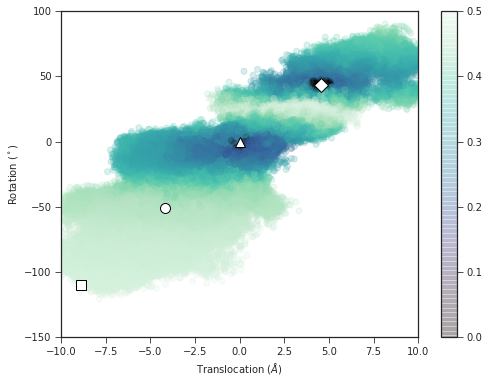

In [28]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=smooth[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

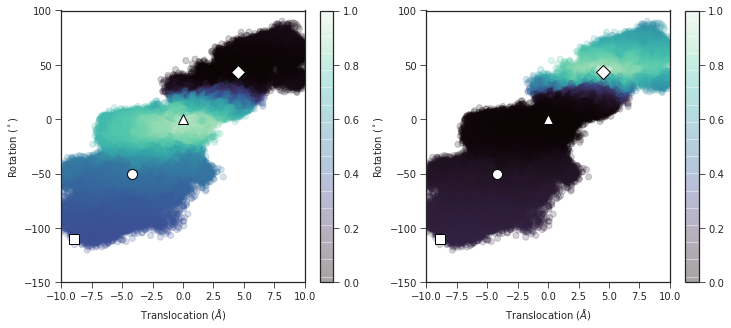

In [29]:
# Plot up and up+ state guess function
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
h0 = ax0.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_up[::10], alpha=0.2, cmap="mako"
)
h1 = ax1.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h0, ax=ax0)
plt.colorbar(h1, ax=ax1)
util.format_cvs(ax0)
util.format_cvs(ax1)

### SVD 

In [30]:
def svd_whiten(X, num_retain=None):
    U, L, V = np.linalg.svd(X, full_matrices=False)
    if num_retain is None:
        return U
    else:
        return U[:, :num_retain]

In [31]:
basis_smooth = smooth * embed_arr
print(basis_smooth.shape)
# basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.)
basis_white = svd_whiten(basis_smooth)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(2952600, 88)
(2952600, 88)


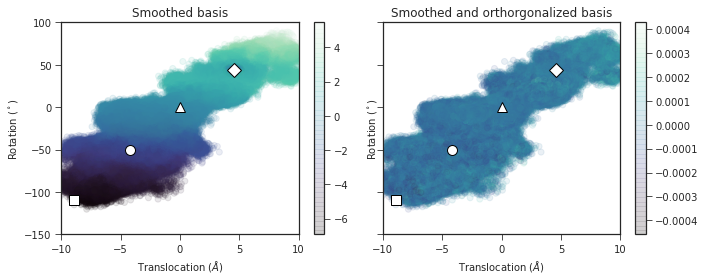

In [32]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
h2 = ax2.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

### Make bases

In [41]:
basisF = np.split(basis_white, lifted_traj_inds)
# "down" state is up, "up" state is up+
guessD = np.split(np.squeeze(guess_up), lifted_traj_inds)
guessU = np.split(np.squeeze(guess_upp), lifted_traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessD))
print(len(guessU))

237 (9800, 88)
237
237


## Weights 

In [42]:
# unit is 0.1 ps, up to 500 ns
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [43]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(embed_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000
Computing change of measure for lag 5000


In [44]:
np.save("../../data/delay_embed/sb6cv_1ns_10embed/coms", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [45]:
print(len(weights), len(weights[0]), weights[0][0].shape)

12 237 (9800,)


## Committors 

In [46]:
in_domain = np.split(mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [47]:
q_downup, q_updown, qb_downup, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


In [48]:
np.save("../../data/delay_embed/sb6cv_1ns_10embed/q_downup", q_downup)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/qb_downup", qb_downup)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/q_updown", q_updown)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/qb_updown", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Forward committor

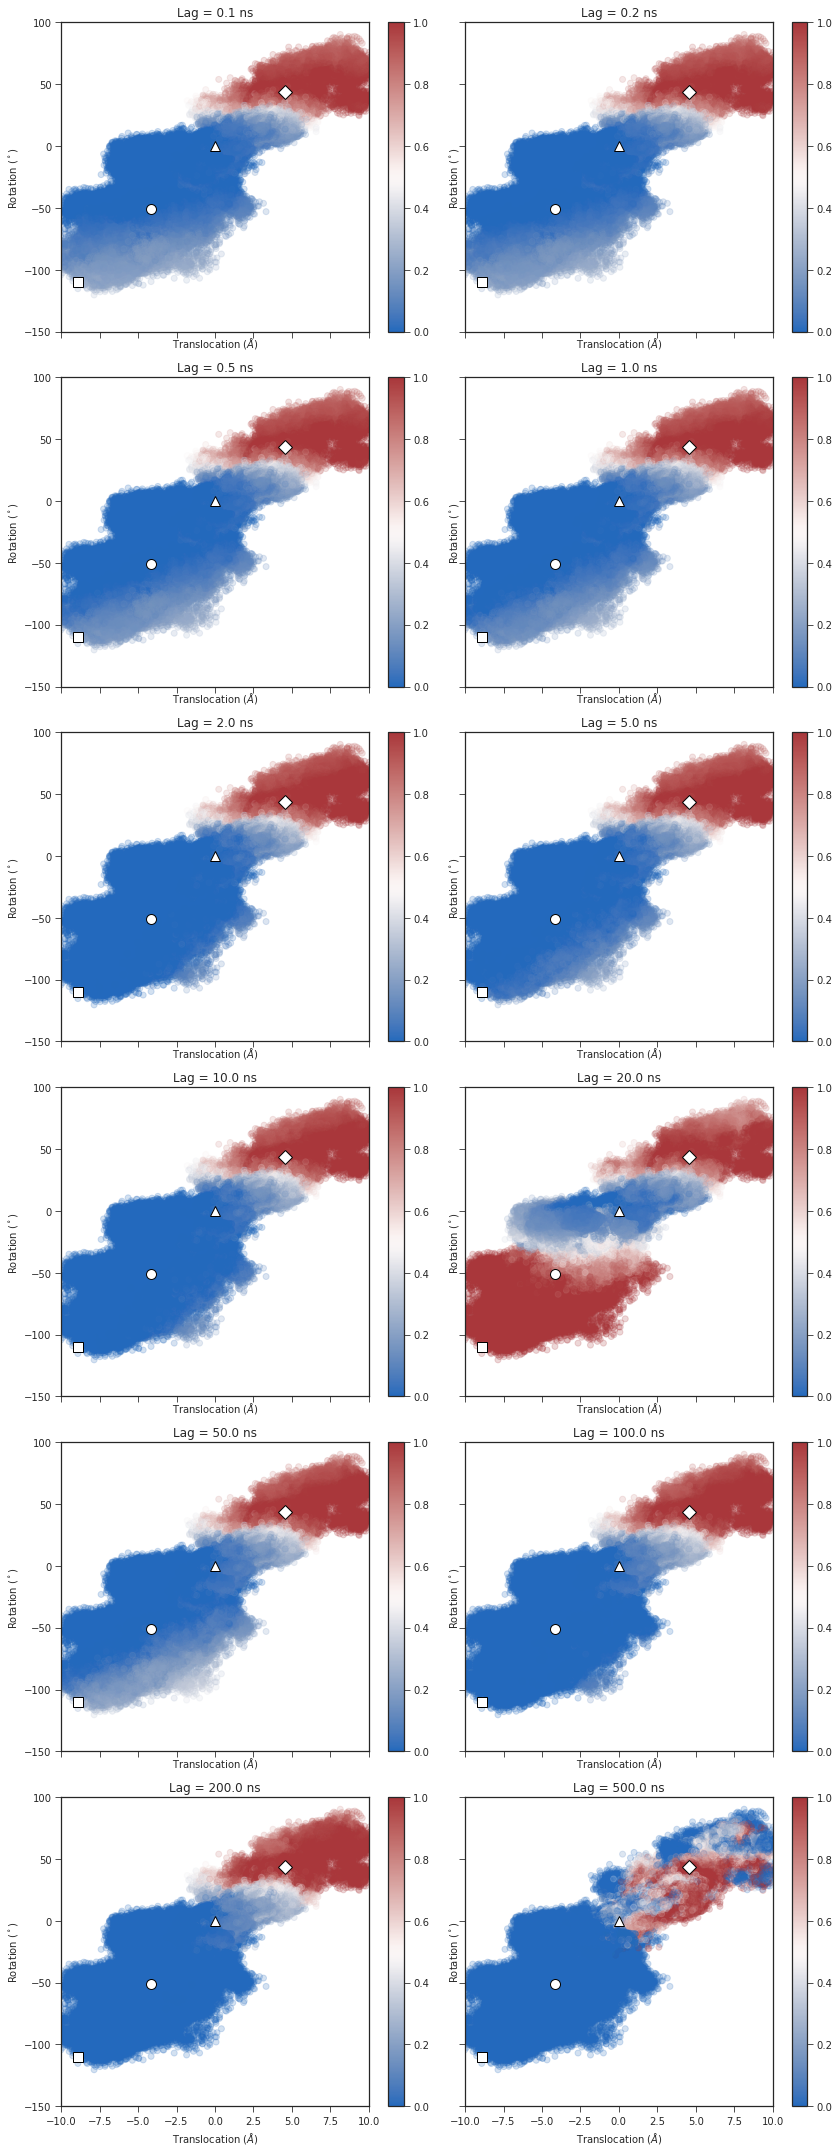

In [49]:
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cvs[::10].T, c=q_arr[::10], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()

In [50]:
# useful salt bridges for up to up+ transition
# R229-D129, R232-D129, R229-D186, R232-D186
sb_ids_uu = [48, 54, 53, 59]

In [51]:
from itertools import combinations

In [52]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

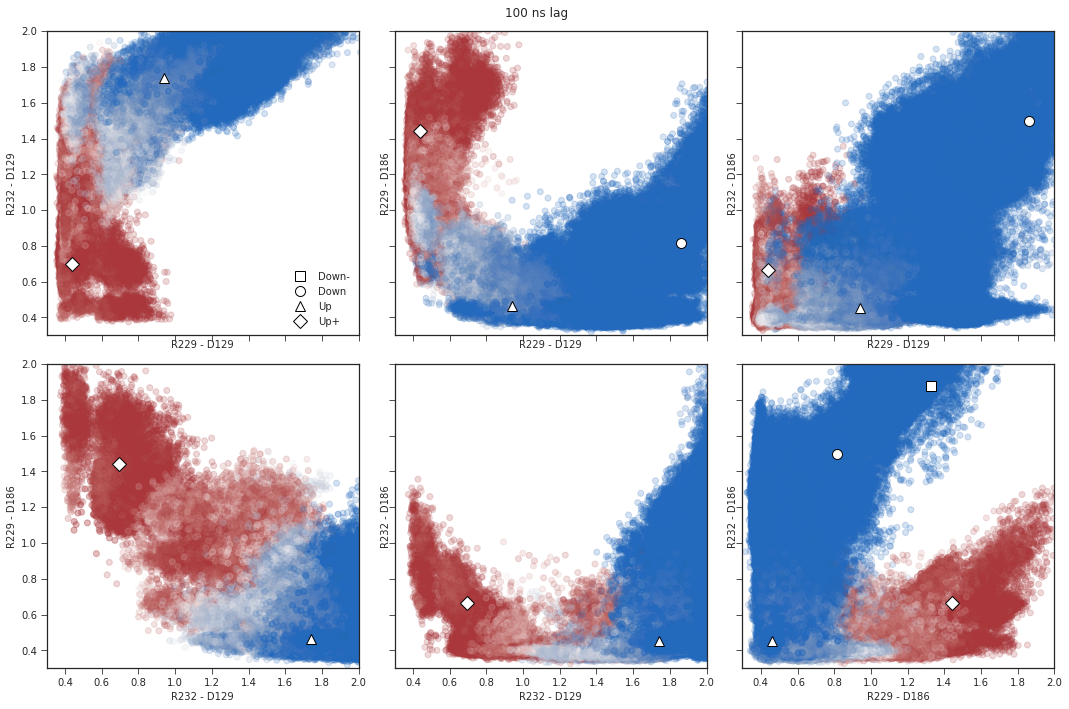

In [53]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 20 ns lag
q_arr = np.concatenate(q_downup[9]).clip(min=0.0, max=1.0)
for ((sb1, sb2), ax) in zip(combinations(sb_ids_uu, 2), axes.flat):
    ax.scatter(
        lifted_sbs[::10, sb1],
        lifted_sbs[::10, sb2],
        c=q_arr[::10],
        cmap="vlag",
        alpha=0.2,
    )
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("100 ns lag")
f.tight_layout()

# With TICA coordinates

6.30.21

In [71]:
n_embed = 20
lag = 10  # 1 ns
# 6 salt bridges + top 4 non trivial TICA coordinates
data_orig = [
    np.hstack((ivac_traj[:, 1:5], traj[:, sb_ids]))
    for (ivac_traj, traj) in zip(ivac_trajs, data_trajs)
]
embed_trajs = delay_embed(data_orig, n_embed, lag)
embed_arr = np.concatenate(embed_trajs)

In [72]:
data_orig[0].shape

(10000, 10)

In [73]:
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

237 (9800, 210)
(2952600, 210)


In [74]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
tic2 = livac_arr[:, 2]
sb5 = data_arr[:, 47]  # R2-D186
sb6 = data_arr[:, 53]  # R3-D186
sb7 = data_arr[:, 59]  # R4-D186


# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

# ellipse centered at (0, 0) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for up state
# take points where TIC 2 > -1.0 and R3/R4-D186 salt bridges < 0.5/0.6 nm, R2-D186 > 1
up_ids = (
    (((dist / 0.84) ** 2 + (rot / 7.6) ** 2) < 1)
    & (sb6 < 0.5)
    & (sb7 < 0.6)
    & (sb5 > 1.0)
    & (tic2 > -1)
).nonzero()[0]

In [75]:
print(len(upplus_ids), len(up_ids))

24530 9054


In [76]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[upplus_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# split into lists of trajectories
upplus = np.zeros(len(cv_arr), dtype=np.float)
upplus[upplus_ids] = True
upplus = np.split(upplus, orig_traj_inds)
up = np.zeros(len(cv_arr), dtype=np.float)
up[up_ids] = True
up = np.split(up, orig_traj_inds)

In [77]:
# delay embed indicator functions for states
lifted_up = lift_function(up, n_embed, lag=lag)
lifted_upplus = lift_function(upplus, n_embed, lag=lag)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_upplus), lifted_upplus[0].shape)

237 (9800,)
237 (9800,)


In [78]:
# lift CV data
lifted_cvs = lift_function(cv_trajs, n_embed, lag=lag)
lifted_sbs = lift_function(data_trajs, n_embed, lag=lag)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)

237 (9800, 2)
237 (9800, 60)


In [79]:
lifted_cvs = np.concatenate(lifted_cvs)
lifted_sbs = np.concatenate(lifted_sbs)
print(lifted_cvs.shape, lifted_sbs.shape)

(2952600, 2) (2952600, 60)


In [80]:
# assert (len(upplus_ids) + len(up_ids) + len(mask)) == len(cv_arr)
print(f"Number of up+ structures:  {len(upplus_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
# print(f'Number of other structures: {len(other)}')

Number of up+ structures:  24530
Number of up structures:   9054


In [81]:
lifted_traj_lens = [len(traj) for traj in embed_trajs]
lifted_traj_inds = []
subtot = 0
for length in lifted_traj_lens[:-1]:
    subtot += length
    lifted_traj_inds.append(subtot)

# new up and upplus ids
up_arr = np.concatenate(lifted_up)
up_ids_lifted = up_arr.nonzero()[0]
upplus_arr = np.concatenate(lifted_upplus)
upplus_ids_lifted = upplus_arr.nonzero()[0]

# states in data
up_data = embed_arr[up_ids_lifted]
upplus_data = embed_arr[upplus_ids_lifted]
print(len(up_data), len(upplus_data))

8217 24160


## Pairwise distances

### Up state 

In [82]:
d_up = []
counter = 0.0
tot = len(data_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, up_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.54% completed
1.09% completed
1.63% completed
2.18% completed
2.72% completed
3.27% completed
3.81% completed
4.36% completed
4.90% completed
5.44% completed
5.99% completed
6.53% completed
7.08% completed
7.62% completed
8.17% completed
8.71% completed
9.26% completed
9.80% completed
10.34% completed
10.89% completed
11.43% completed
11.98% completed
12.52% completed
13.07% completed
13.61% completed
14.16% completed
14.70% completed
15.25% completed
15.79% completed
16.33% completed
16.88% completed
17.42% completed
17.97% completed
18.51% completed
19.06% completed
19.60% completed
20.15% completed
20.69% completed
21.23% completed
21.78% completed
22.32% completed
22.87% completed
23.41% completed
23.96% completed
24.50% completed
25.05% completed
25.59% completed
26.13% completed
26.68% completed
27.22% completed
27.77% completed
28.31% completed
28.86% completed
29.40% completed
29.95% completed
30.49% completed
31.03% completed
31.58% completed
32.12% completed
32.67% complete

In [83]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids_lifted]))
d_up_arr[up_ids_lifted] = 0
print(np.max(d_up_arr[up_ids_lifted]))

print(d_up_arr.shape)

181 (16334,)
(2952600, 1)
6.307962682401158e-07
0.0
(2952600, 1)


In [84]:
np.save("../../data/delay_embed/sb6tica_1ns_20embed/dist_up.npy", d_up_arr)

In [24]:
d_up_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_up.npy")

### Up+state

In [85]:
d_upp = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, upplus_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.19% completed
0.37% completed
0.56% completed
0.74% completed
0.93% completed
1.11% completed
1.30% completed
1.48% completed
1.67% completed
1.85% completed
2.04% completed
2.22% completed
2.41% completed
2.59% completed
2.78% completed
2.96% completed
3.15% completed
3.33% completed
3.52% completed
3.70% completed
3.89% completed
4.07% completed
4.26% completed
4.44% completed
4.63% completed
4.81% completed
5.00% completed
5.18% completed
5.37% completed
5.56% completed
5.74% completed
5.93% completed
6.11% completed
6.30% completed
6.48% completed
6.67% completed
6.85% completed
7.04% completed
7.22% completed
7.41% completed
7.59% completed
7.78% completed
7.96% completed
8.15% completed
8.33% completed
8.52% completed
8.70% completed
8.89% completed
9.07% completed
9.26% completed
9.44% completed
9.63% completed
9.81% completed
10.00% completed
10.18% completed
10.37% completed
10.55% completed
10.74% completed
10.92% completed
11.11% completed
11.30% completed
11.48% completed

90.18% completed
90.36% completed
90.55% completed
90.73% completed
90.92% completed
91.10% completed
91.29% completed
91.47% completed
91.66% completed
91.84% completed
92.03% completed
92.21% completed
92.40% completed
92.58% completed
92.77% completed
92.95% completed
93.14% completed
93.32% completed
93.51% completed
93.69% completed
93.88% completed
94.06% completed
94.25% completed
94.44% completed
94.62% completed
94.81% completed
94.99% completed
95.18% completed
95.36% completed
95.55% completed
95.73% completed
95.92% completed
96.10% completed
96.29% completed
96.47% completed
96.66% completed
96.84% completed
97.03% completed
97.21% completed
97.40% completed
97.58% completed
97.77% completed
97.95% completed
98.14% completed
98.32% completed
98.42% completed


In [86]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_up_arr[upplus_ids_lifted]))
d_upp_arr[upplus_ids_lifted] = 0
print(np.max(d_upp_arr[upplus_ids_lifted]))

print(d_upp_arr.shape)

532 (5555,)
(2952600, 1)
19.25856527480164
0.0
(2952600, 1)


In [87]:
np.save("../../data/delay_embed/sb6tica_1ns_20embed/dist_upplus.npy", d_upp_arr)

In [25]:
d_upp_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_upplus.npy")

## Basis set construction 

In [88]:
# make smoothing function
smooth = (d_up_arr * d_upp_arr) ** 0.5 / (d_up_arr + d_upp_arr)

# make guess
guess_up = (d_upp_arr / (d_up_arr + d_upp_arr)) ** 2
guess_upp = (d_up_arr / (d_up_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (up and up+ states)
mask = np.ones(len(embed_arr), dtype=bool)
mask[up_ids_lifted] = False
mask[upplus_ids_lifted] = False
smooth[(mask == 0).flatten()] = 0

# ensure homogeneous boundary conditions for guess
guess_up[up_ids_lifted] = 1
guess_up[upplus_ids_lifted] = 0
guess_upp[upplus_ids_lifted] = 1
guess_upp[up_ids_lifted] = 0

In [89]:
print(smooth.shape, guess_up.shape, guess_upp.shape)

(2952600, 1) (2952600, 1) (2952600, 1)


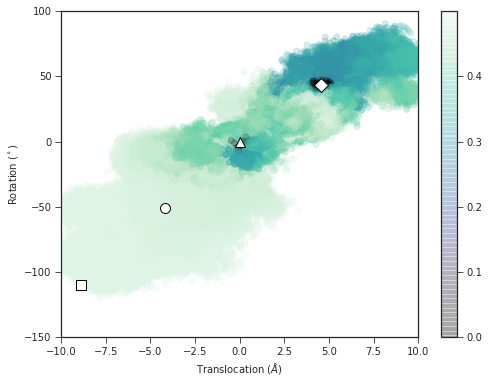

In [90]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=smooth[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

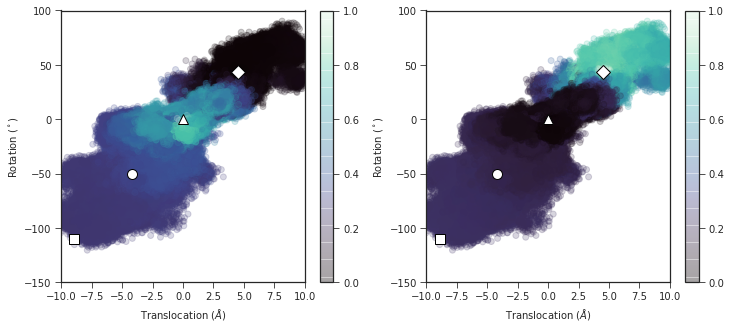

In [91]:
# Plot up and up+ state guess function
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
h0 = ax0.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_up[::10], alpha=0.2, cmap="mako"
)
h1 = ax1.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h0, ax=ax0)
plt.colorbar(h1, ax=ax1)
util.format_cvs(ax0)
util.format_cvs(ax1)

### SVD 

In [92]:
basis_smooth = smooth * embed_arr
print(basis_smooth.shape)
# basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.)
basis_white = svd_whiten(basis_smooth)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(2952600, 210)
(2952600, 210)


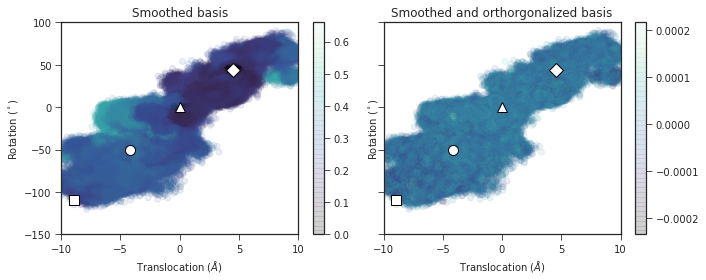

In [93]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
h2 = ax2.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

### Make bases

In [94]:
basisF = np.split(basis_white, lifted_traj_inds)
# "down" state is up, "up" state is up+
guessD = np.split(np.squeeze(guess_up), lifted_traj_inds)
guessU = np.split(np.squeeze(guess_upp), lifted_traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessD))
print(len(guessU))

237 (9800, 210)
237
237


## Weights 

In [95]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(embed_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000
Computing change of measure for lag 5000


In [96]:
np.save("../../data/delay_embed/sb6tica_1ns_20embed/coms", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [97]:
print(len(weights), len(weights[0]), weights[0][0].shape)

12 237 (9800,)


## Committors 

In [98]:
in_domain = np.split(mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [99]:
q_downup, q_updown, qb_downup, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


In [100]:
np.save("../../data/delay_embed/sb6tica_1ns_20embed/q_downup", q_downup)
np.save("../../data/delay_embed/sb6tica_1ns_20embed/qb_downup", qb_downup)
np.save("../../data/delay_embed/sb6tica_1ns_20embed/q_updown", q_updown)
np.save("../../data/delay_embed/sb6tica_1ns_20embed/qb_updown", qb_updown)

### Forward committor

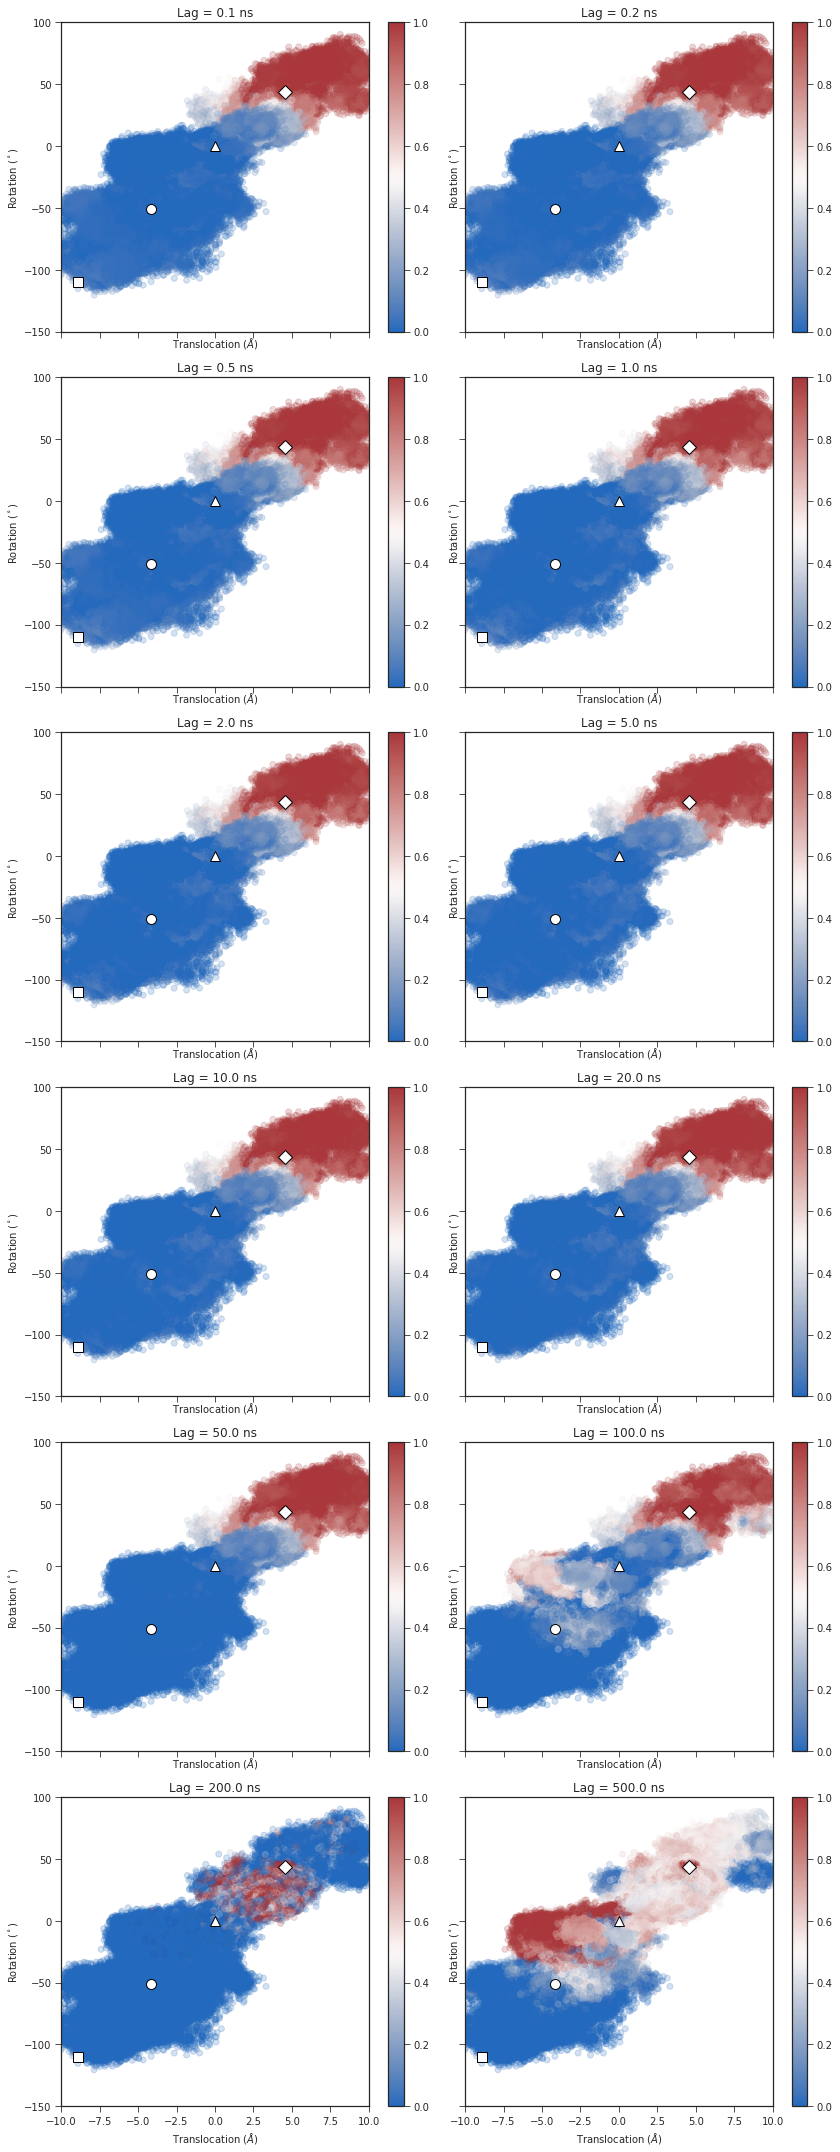

In [101]:
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cvs[::10].T, c=q_arr[::10], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()

In [102]:
# useful salt bridges for up to up+ transition
# R229-D129, R232-D129, R229-D186, R232-D186
sb_ids_uu = [48, 54, 53, 59]

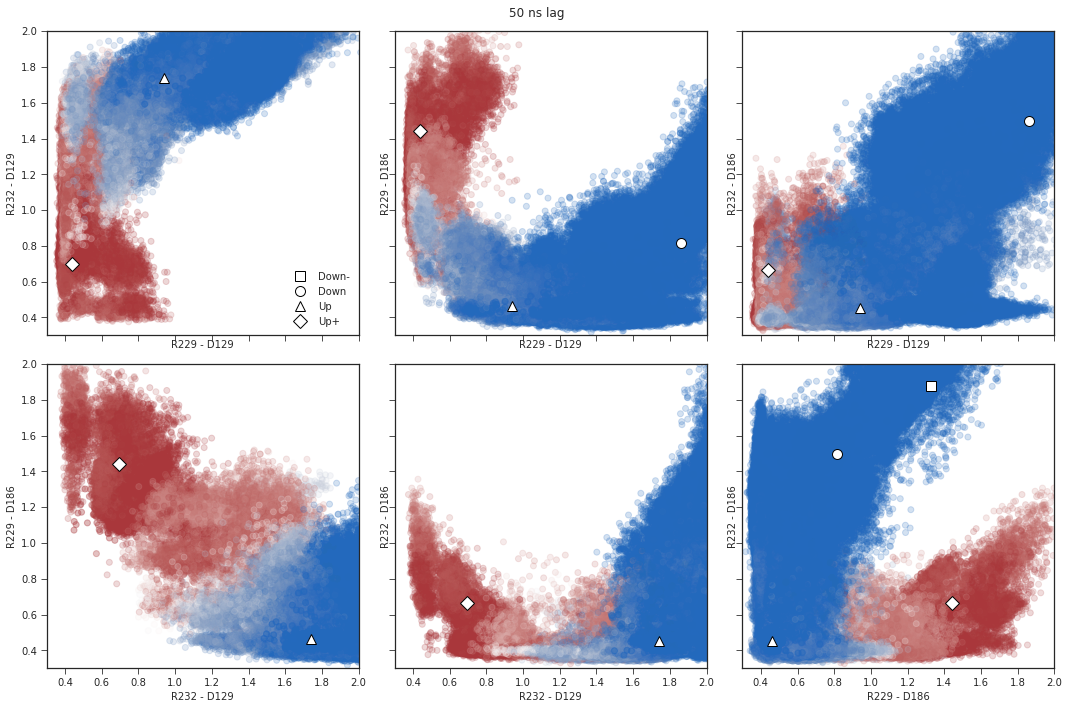

In [103]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
# 20 ns lag
q_arr = np.concatenate(q_downup[8]).clip(min=0.0, max=1.0)
for ((sb1, sb2), ax) in zip(combinations(sb_ids_uu, 2), axes.flat):
    ax.scatter(
        lifted_sbs[::10, sb1],
        lifted_sbs[::10, sb2],
        c=q_arr[::10],
        cmap="vlag",
        alpha=0.2,
    )
    ax.set(xlabel=sb_labels[sb1 - 30], ylabel=sb_labels[sb2 - 30])

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
util.plot_models(axes[0][0], feat2_models[:, 48:55:6])  # indexes 48 and 54
util.plot_models(axes[0][1], feat2_models[:, 48:54:5])  # 48 and 53
util.plot_models(axes[0][2], feat2_models[:, 48:60:11])  # 48 and 59
util.plot_models(axes[1][0], feat2_models[:, 54:52:-1])  # indexes 54 and 53
util.plot_models(axes[1][1], feat2_models[:, 54:60:5])  # 54 and 59
util.plot_models(axes[1][2], feat2_models[:, 53:60:6])  # 53 and 59
axes[0][0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("50 ns lag")
f.tight_layout()

# Rerun calculations with CVs and correct delay 

In [104]:
n_embed = 20
lag = 10
# use smaller input feature set
# R223-D129, R226-D129, R226-D186, R229-D129, R229-D186, R232-D186
sb_ids = [36, 42, 47, 48, 53, 59]
data_orig = [
    np.hstack((cv_traj, traj[:, sb_ids]))
    for (cv_traj, traj) in zip(cv_trajs, data_trajs)
]
embed_trajs = delay_embed(data_orig, n_embed, lag)
embed_arr = np.concatenate(embed_trajs)

In [105]:
data_orig[0].shape

(10000, 8)

In [106]:
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

237 (9800, 168)
(2952600, 168)


In [107]:
orig_traj_lens = [len(traj) for traj in livac_trajs]
orig_traj_inds = []
subtot = 0
for length in orig_traj_lens[:-1]:
    subtot += length
    orig_traj_inds.append(subtot)

In [108]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
tic2 = livac_arr[:, 2]
sb5 = data_arr[:, 47]  # R2-D186
sb6 = data_arr[:, 53]  # R3-D186
sb7 = data_arr[:, 59]  # R4-D186


# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

# ellipse centered at (0, 0) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for up state
# take points where TIC 2 > -1.0 and R3/R4-D186 salt bridges < 0.5/0.6 nm, R2-D186 > 1
up_ids = (
    (((dist / 0.84) ** 2 + (rot / 7.6) ** 2) < 1)
    & (sb6 < 0.5)
    & (sb7 < 0.6)
    & (sb5 > 1.0)
    & (tic2 > -1)
).nonzero()[0]

In [109]:
print(len(upplus_ids), len(up_ids))

24530 9054


In [110]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[upplus_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# split into lists of trajectories
upplus = np.zeros(len(cv_arr), dtype=np.float)
upplus[upplus_ids] = True
upplus = np.split(upplus, orig_traj_inds)
up = np.zeros(len(cv_arr), dtype=np.float)
up[up_ids] = True
up = np.split(up, orig_traj_inds)

In [111]:
# delay embed indicator functions for states
lifted_up = lift_function(up, n_embed, lag=lag)
lifted_upplus = lift_function(upplus, n_embed, lag=lag)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_upplus), lifted_upplus[0].shape)

237 (9800,)
237 (9800,)


In [112]:
len(up_ids)

9054

In [113]:
# lift CV data
lifted_cvs = lift_function(cv_trajs, n_embed, lag=lag)
lifted_sbs = lift_function(data_trajs, n_embed, lag=lag)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)

237 (9800, 2)
237 (9800, 60)


In [114]:
lifted_cvs = np.concatenate(lifted_cvs)
lifted_sbs = np.concatenate(lifted_sbs)
print(lifted_cvs.shape, lifted_sbs.shape)

(2952600, 2) (2952600, 60)


In [115]:
# assert (len(upplus_ids) + len(up_ids) + len(mask)) == len(cv_arr)
print(f"Number of up+ structures:  {len(upplus_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
# print(f'Number of other structures: {len(other)}')

Number of up+ structures:  24530
Number of up structures:   9054


In [116]:
lifted_traj_lens = [len(traj) for traj in embed_trajs]
lifted_traj_inds = []
subtot = 0
for length in lifted_traj_lens[:-1]:
    subtot += length
    lifted_traj_inds.append(subtot)

# new up and upplus ids
up_arr = np.concatenate(lifted_up)
up_ids_lifted = up_arr.nonzero()[0]
upplus_arr = np.concatenate(lifted_upplus)
upplus_ids_lifted = upplus_arr.nonzero()[0]

# states in data
up_data = embed_arr[up_ids_lifted]
upplus_data = embed_arr[upplus_ids_lifted]
print(len(up_data), len(upplus_data))

8217 24160


## Pairwise distances

In [117]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

### Up state 

In [118]:
d_up = []
counter = 0.0
tot = len(data_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, up_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.54% completed
1.09% completed
1.63% completed
2.18% completed
2.72% completed
3.27% completed
3.81% completed
4.36% completed
4.90% completed
5.44% completed
5.99% completed
6.53% completed
7.08% completed
7.62% completed
8.17% completed
8.71% completed
9.26% completed
9.80% completed
10.34% completed
10.89% completed
11.43% completed
11.98% completed
12.52% completed
13.07% completed
13.61% completed
14.16% completed
14.70% completed
15.25% completed
15.79% completed
16.33% completed
16.88% completed
17.42% completed
17.97% completed
18.51% completed
19.06% completed
19.60% completed
20.15% completed
20.69% completed
21.23% completed
21.78% completed
22.32% completed
22.87% completed
23.41% completed
23.96% completed
24.50% completed
25.05% completed
25.59% completed
26.13% completed
26.68% completed
27.22% completed
27.77% completed
28.31% completed
28.86% completed
29.40% completed
29.95% completed
30.49% completed
31.03% completed
31.58% completed
32.12% completed
32.67% complete

In [119]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids_lifted]))
d_up_arr[up_ids_lifted] = 0
print(np.max(d_up_arr[up_ids_lifted]))

print(d_up_arr.shape)

181 (16334,)
(2952600, 1)
1.9073486328125e-06
0.0
(2952600, 1)


In [120]:
np.save("../../data/delay_embed/sb6cv_1ns_20embed/dist_up.npy", d_up_arr)

In [24]:
d_up_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_up.npy")

### Up+state

In [121]:
d_upp = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, upplus_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.19% completed
0.37% completed
0.56% completed
0.74% completed
0.93% completed
1.11% completed
1.30% completed
1.48% completed
1.67% completed
1.85% completed
2.04% completed
2.22% completed
2.41% completed
2.59% completed
2.78% completed
2.96% completed
3.15% completed
3.33% completed
3.52% completed
3.70% completed
3.89% completed
4.07% completed
4.26% completed
4.44% completed
4.63% completed
4.81% completed
5.00% completed
5.18% completed
5.37% completed
5.56% completed
5.74% completed
5.93% completed
6.11% completed
6.30% completed
6.48% completed
6.67% completed
6.85% completed
7.04% completed
7.22% completed
7.41% completed
7.59% completed
7.78% completed
7.96% completed
8.15% completed
8.33% completed
8.52% completed
8.70% completed
8.89% completed
9.07% completed
9.26% completed
9.44% completed
9.63% completed
9.81% completed
10.00% completed
10.18% completed
10.37% completed
10.55% completed
10.74% completed
10.92% completed
11.11% completed
11.30% completed
11.48% completed

90.18% completed
90.36% completed
90.55% completed
90.73% completed
90.92% completed
91.10% completed
91.29% completed
91.47% completed
91.66% completed
91.84% completed
92.03% completed
92.21% completed
92.40% completed
92.58% completed
92.77% completed
92.95% completed
93.14% completed
93.32% completed
93.51% completed
93.69% completed
93.88% completed
94.06% completed
94.25% completed
94.44% completed
94.62% completed
94.81% completed
94.99% completed
95.18% completed
95.36% completed
95.55% completed
95.73% completed
95.92% completed
96.10% completed
96.29% completed
96.47% completed
96.66% completed
96.84% completed
97.03% completed
97.21% completed
97.40% completed
97.58% completed
97.77% completed
97.95% completed
98.14% completed
98.32% completed
98.42% completed


In [122]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_up_arr[upplus_ids_lifted]))
d_upp_arr[upplus_ids_lifted] = 0
print(np.max(d_upp_arr[upplus_ids_lifted]))

print(d_upp_arr.shape)

532 (5555,)
(2952600, 1)
227.04200415562534
0.0
(2952600, 1)


In [123]:
np.save("../../data/delay_embed/sb6cv_1ns_20embed/dist_upplus.npy", d_upp_arr)

In [25]:
d_upp_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_upplus.npy")

## Basis set construction 

In [124]:
# make smoothing function
smooth = (d_up_arr * d_upp_arr) ** 0.5 / (d_up_arr + d_upp_arr)

# make guess
guess_up = (d_upp_arr / (d_up_arr + d_upp_arr)) ** 2
guess_upp = (d_up_arr / (d_up_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (up and up+ states)
mask = np.ones(len(embed_arr), dtype=bool)
mask[up_ids_lifted] = False
mask[upplus_ids_lifted] = False
smooth[(mask == 0).flatten()] = 0

# ensure homogeneous boundary conditions for guess
guess_up[up_ids_lifted] = 1
guess_up[upplus_ids_lifted] = 0
guess_upp[upplus_ids_lifted] = 1
guess_upp[up_ids_lifted] = 0

In [125]:
print(smooth.shape, guess_up.shape, guess_upp.shape)

(2952600, 1) (2952600, 1) (2952600, 1)


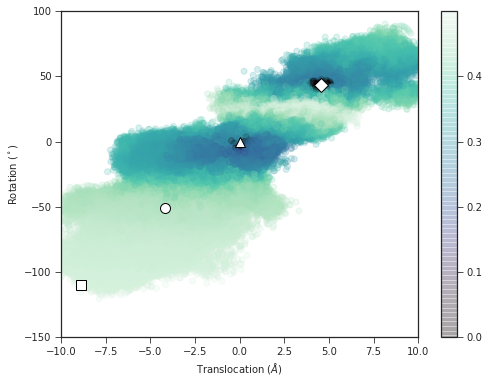

In [126]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=smooth[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

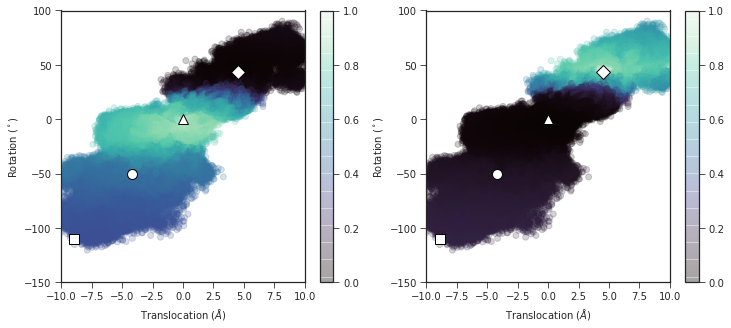

In [127]:
# Plot up and up+ state guess function
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
h0 = ax0.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_up[::10], alpha=0.2, cmap="mako"
)
h1 = ax1.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h0, ax=ax0)
plt.colorbar(h1, ax=ax1)
util.format_cvs(ax0)
util.format_cvs(ax1)

### SVD 

In [128]:
basis_smooth = smooth * embed_arr
print(basis_smooth.shape)
# basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.)
basis_white = svd_whiten(basis_smooth)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(2952600, 168)
(2952600, 168)


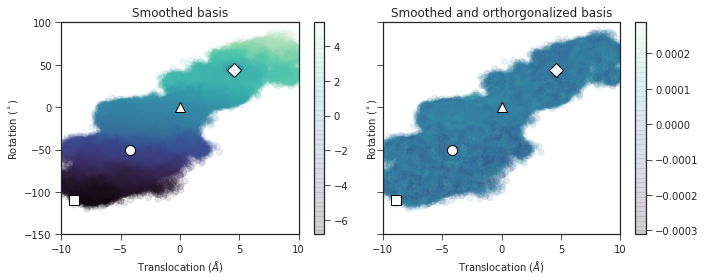

In [129]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
h2 = ax2.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

### Make bases

In [130]:
basisF = np.split(basis_white, lifted_traj_inds)
# "down" state is up, "up" state is up+
guessD = np.split(np.squeeze(guess_up), lifted_traj_inds)
guessU = np.split(np.squeeze(guess_upp), lifted_traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessD))
print(len(guessU))

237 (9800, 168)
237
237


## Weights 

In [131]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(embed_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000
Computing change of measure for lag 5000


In [132]:
np.save("../../data/delay_embed/sb6cv_1ns_20embed/coms", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [133]:
print(len(weights), len(weights[0]), weights[0][0].shape)

12 237 (9800,)


## Committors 

In [134]:
in_domain = np.split(mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [135]:
q_downup, q_updown, qb_downup, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


In [ ]:
np.save("../../data/delay_embed/sb6cv_1ns_20embed/q_downup", q_downup)
np.save("../../data/delay_embed/sb6cv_1ns_20embed/qb_downup", qb_downup)
np.save("../../data/delay_embed/sb6cv_1ns_20embed/q_updown", q_updown)
np.save("../../data/delay_embed/sb6cv_1ns_20embed/qb_updown", qb_updown)

### Forward committor

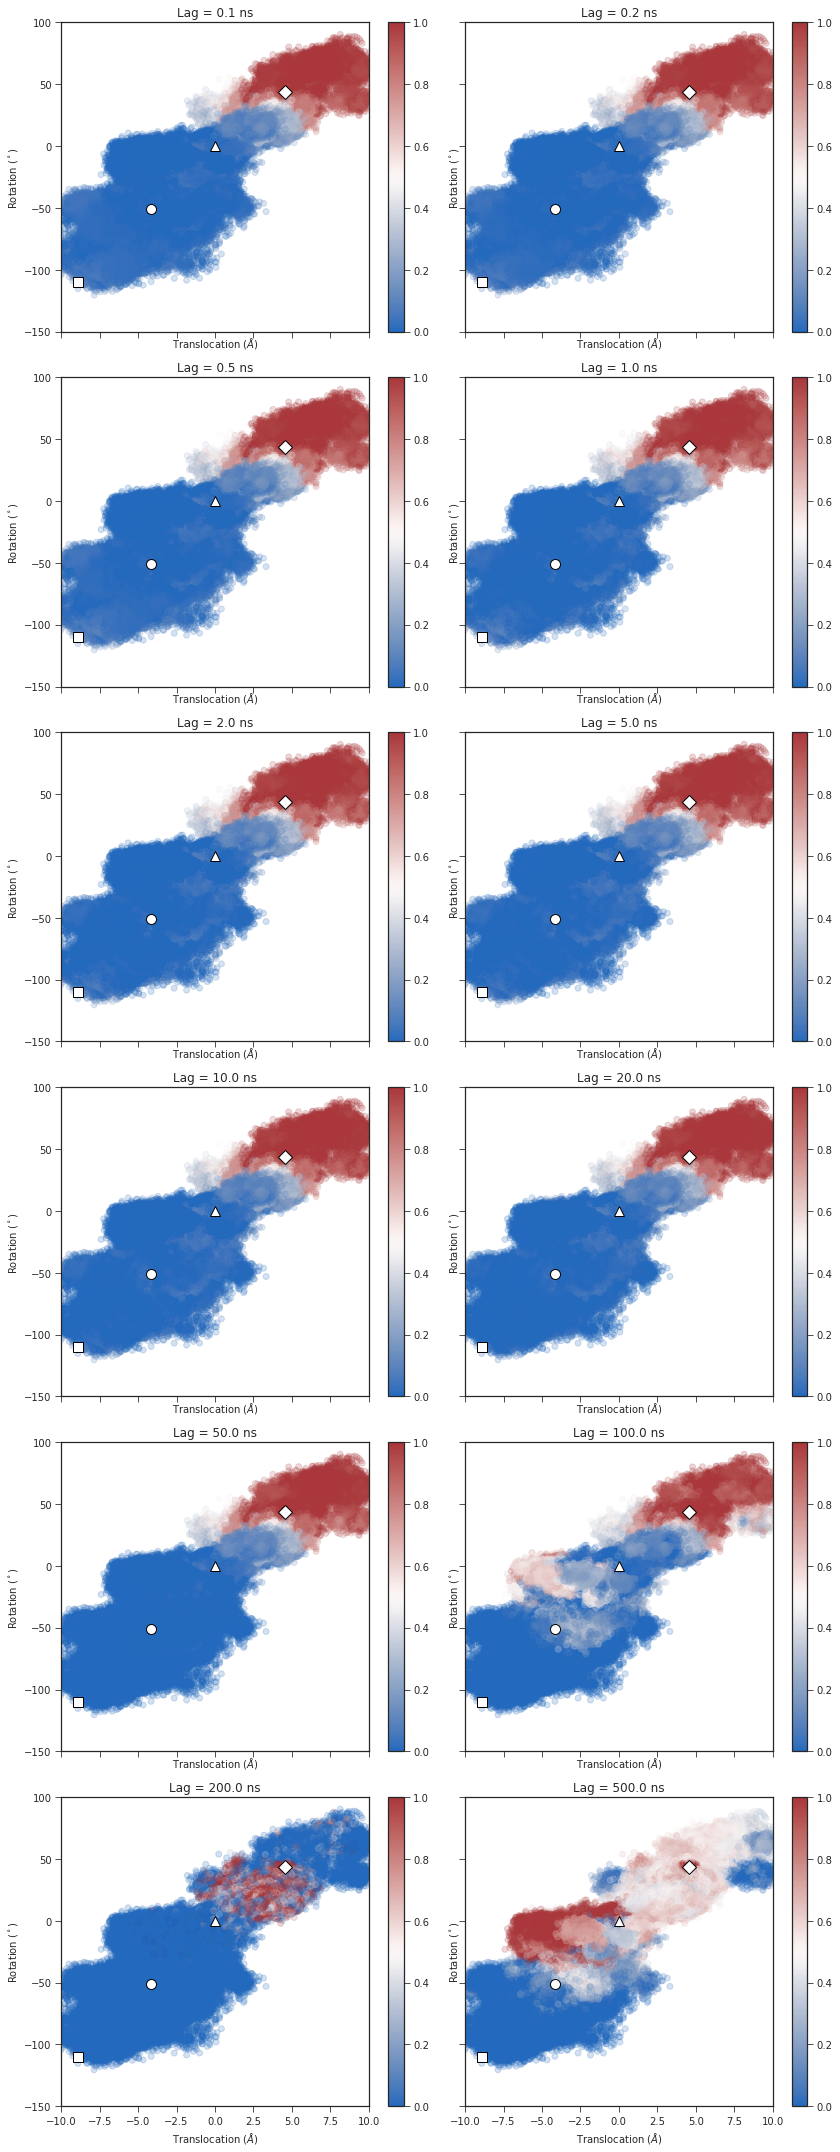

In [101]:
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cvs[::10].T, c=q_arr[::10], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()

# Only TICA coordinates

In [15]:
n_embed = 20
lag = 10
data_orig = [traj[:, :5] for traj in ivac_trajs]
embed_trajs = delay_embed(data_orig, n_embed, lag)
embed_arr = np.concatenate(embed_trajs)

In [16]:
data_orig[0].shape

(10000, 5)

In [17]:
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

237 (9800, 105)
(2952600, 105)


In [18]:
orig_traj_lens = [len(traj) for traj in livac_trajs]
orig_traj_inds = []
subtot = 0
for length in orig_traj_lens[:-1]:
    subtot += length
    orig_traj_inds.append(subtot)

In [19]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
tic2 = livac_arr[:, 2]
sb5 = data_arr[:, 47]  # R2-D186
sb6 = data_arr[:, 53]  # R3-D186
sb7 = data_arr[:, 59]  # R4-D186


# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

# ellipse centered at (0, 0) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for up state
# take points where TIC 2 > -1.0 and R3/R4-D186 salt bridges < 0.5/0.6 nm, R2-D186 > 1
up_ids = (
    (((dist / 0.84) ** 2 + (rot / 7.6) ** 2) < 1)
    & (sb6 < 0.5)
    & (sb7 < 0.6)
    & (sb5 > 1.0)
    & (tic2 > -1)
).nonzero()[0]

In [20]:
print(len(upplus_ids), len(up_ids))

24530 9054


In [21]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[upplus_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# split into lists of trajectories
upplus = np.zeros(len(cv_arr), dtype=np.float)
upplus[upplus_ids] = True
upplus = np.split(upplus, orig_traj_inds)
up = np.zeros(len(cv_arr), dtype=np.float)
up[up_ids] = True
up = np.split(up, orig_traj_inds)

In [22]:
# delay embed indicator functions for states
lifted_up = lift_function(up, n_embed, lag=lag)
lifted_upplus = lift_function(upplus, n_embed, lag=lag)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_upplus), lifted_upplus[0].shape)

237 (9800,)
237 (9800,)


In [23]:
len(up_ids)

9054

In [24]:
# lift CV data
lifted_cvs = lift_function(cv_trajs, n_embed, lag=lag)
lifted_sbs = lift_function(data_trajs, n_embed, lag=lag)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)

237 (9800, 2)
237 (9800, 60)


In [25]:
lifted_cvs = np.concatenate(lifted_cvs)
lifted_sbs = np.concatenate(lifted_sbs)
print(lifted_cvs.shape, lifted_sbs.shape)

(2952600, 2) (2952600, 60)


In [26]:
# assert (len(upplus_ids) + len(up_ids) + len(mask)) == len(cv_arr)
print(f"Number of up+ structures:  {len(upplus_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
# print(f'Number of other structures: {len(other)}')

Number of up+ structures:  24530
Number of up structures:   9054


In [27]:
lifted_traj_lens = [len(traj) for traj in embed_trajs]
lifted_traj_inds = []
subtot = 0
for length in lifted_traj_lens[:-1]:
    subtot += length
    lifted_traj_inds.append(subtot)

# new up and upplus ids
up_arr = np.concatenate(lifted_up)
up_ids_lifted = up_arr.nonzero()[0]
upplus_arr = np.concatenate(lifted_upplus)
upplus_ids_lifted = upplus_arr.nonzero()[0]

# states in data
up_data = embed_arr[up_ids_lifted]
upplus_data = embed_arr[upplus_ids_lifted]
print(len(up_data), len(upplus_data))

8217 24160


## Pairwise distances

In [28]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

### Up state 

In [29]:
d_up = []
counter = 0.0
tot = len(data_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, up_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.54% completed
1.09% completed
1.63% completed
2.18% completed
2.72% completed
3.27% completed
3.81% completed
4.36% completed
4.90% completed
5.44% completed
5.99% completed
6.53% completed
7.08% completed
7.62% completed
8.17% completed
8.71% completed
9.26% completed
9.80% completed
10.34% completed
10.89% completed
11.43% completed
11.98% completed
12.52% completed
13.07% completed
13.61% completed
14.16% completed
14.70% completed
15.25% completed
15.79% completed
16.33% completed
16.88% completed
17.42% completed
17.97% completed
18.51% completed
19.06% completed
19.60% completed
20.15% completed
20.69% completed
21.23% completed
21.78% completed
22.32% completed
22.87% completed
23.41% completed
23.96% completed
24.50% completed
25.05% completed
25.59% completed
26.13% completed
26.68% completed
27.22% completed
27.77% completed
28.31% completed
28.86% completed
29.40% completed
29.95% completed
30.49% completed
31.03% completed
31.58% completed
32.12% completed
32.67% complete

In [30]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids_lifted]))
d_up_arr[up_ids_lifted] = 0
print(np.max(d_up_arr[up_ids_lifted]))

print(d_up_arr.shape)

181 (16334,)
(2952600, 1)
3.371747880871523e-07
0.0
(2952600, 1)


In [32]:
np.save("../../data/delay_embed/tica_1ns_20embed/dist_up.npy", d_up_arr)

In [24]:
d_up_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_up.npy")

### Up+state

In [34]:
d_upp = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    embed_arr, upplus_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.19% completed
0.37% completed
0.56% completed
0.74% completed
0.93% completed
1.11% completed
1.30% completed
1.48% completed
1.67% completed
1.85% completed
2.04% completed
2.22% completed
2.41% completed
2.59% completed
2.78% completed
2.96% completed
3.15% completed
3.33% completed
3.52% completed
3.70% completed
3.89% completed
4.07% completed
4.26% completed
4.44% completed
4.63% completed
4.81% completed
5.00% completed
5.18% completed
5.37% completed
5.56% completed
5.74% completed
5.93% completed
6.11% completed
6.30% completed
6.48% completed
6.67% completed
6.85% completed
7.04% completed
7.22% completed
7.41% completed
7.59% completed
7.78% completed
7.96% completed
8.15% completed
8.33% completed
8.52% completed
8.70% completed
8.89% completed
9.07% completed
9.26% completed
9.44% completed
9.63% completed
9.81% completed
10.00% completed
10.18% completed
10.37% completed
10.55% completed
10.74% completed
10.92% completed
11.11% completed
11.30% completed
11.48% completed

90.18% completed
90.36% completed
90.55% completed
90.73% completed
90.92% completed
91.10% completed
91.29% completed
91.47% completed
91.66% completed
91.84% completed
92.03% completed
92.21% completed
92.40% completed
92.58% completed
92.77% completed
92.95% completed
93.14% completed
93.32% completed
93.51% completed
93.69% completed
93.88% completed
94.06% completed
94.25% completed
94.44% completed
94.62% completed
94.81% completed
94.99% completed
95.18% completed
95.36% completed
95.55% completed
95.73% completed
95.92% completed
96.10% completed
96.29% completed
96.47% completed
96.66% completed
96.84% completed
97.03% completed
97.21% completed
97.40% completed
97.58% completed
97.77% completed
97.95% completed
98.14% completed
98.32% completed
98.42% completed


In [35]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_up_arr[upplus_ids_lifted]))
d_upp_arr[upplus_ids_lifted] = 0
print(np.max(d_upp_arr[upplus_ids_lifted]))

print(d_upp_arr.shape)

532 (5555,)
(2952600, 1)
17.9435223437166
0.0
(2952600, 1)


In [36]:
np.save("../../data/delay_embed/tica_1ns_20embed/dist_upplus.npy", d_upp_arr)

In [ ]:
d_upp_arr = np.load("../../data/delay_embed/sb6cv_1ns_10embed/dist_upplus.npy")

## Basis set construction 

In [37]:
# make smoothing function
smooth = (d_up_arr * d_upp_arr) ** 0.5 / (d_up_arr + d_upp_arr)

# make guess
guess_up = (d_upp_arr / (d_up_arr + d_upp_arr)) ** 2
guess_upp = (d_up_arr / (d_up_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (up and up+ states)
mask = np.ones(len(embed_arr), dtype=bool)
mask[up_ids_lifted] = False
mask[upplus_ids_lifted] = False
smooth[(mask == 0).flatten()] = 0

# ensure homogeneous boundary conditions for guess
guess_up[up_ids_lifted] = 1
guess_up[upplus_ids_lifted] = 0
guess_upp[upplus_ids_lifted] = 1
guess_upp[up_ids_lifted] = 0

In [38]:
print(smooth.shape, guess_up.shape, guess_upp.shape)

(2952600, 1) (2952600, 1) (2952600, 1)


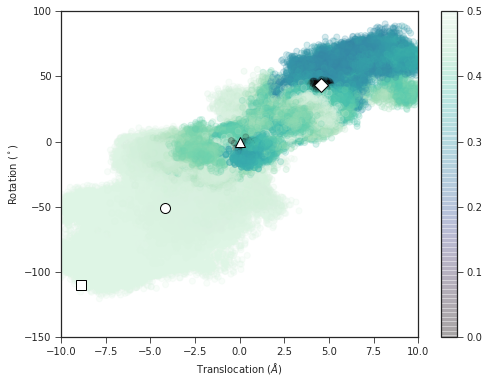

In [39]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=smooth[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

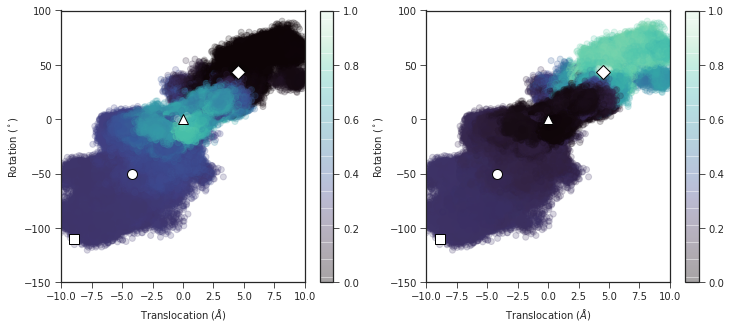

In [40]:
# Plot up and up+ state guess function
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
h0 = ax0.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_up[::10], alpha=0.2, cmap="mako"
)
h1 = ax1.scatter(
    lifted_cvs[::10, 0], lifted_cvs[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="mako"
)
plt.colorbar(h0, ax=ax0)
plt.colorbar(h1, ax=ax1)
util.format_cvs(ax0)
util.format_cvs(ax1)

### SVD 

In [41]:
def svd_whiten(X, num_retain=None):
    U, L, V = np.linalg.svd(X, full_matrices=False)
    if num_retain is None:
        return U
    else:
        return U[:, :num_retain]

In [42]:
basis_smooth = smooth * embed_arr
print(basis_smooth.shape)
# basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.)
basis_white = svd_whiten(basis_smooth)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(2952600, 105)
(2952600, 105)


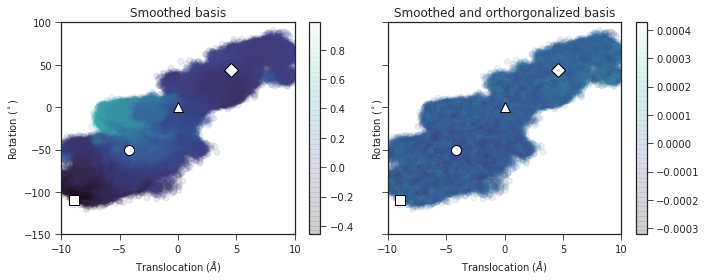

In [43]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
h2 = ax2.scatter(
    lifted_cvs[::10, 0],
    lifted_cvs[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="mako",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

### Make bases

In [44]:
basisF = np.split(basis_white, lifted_traj_inds)
# "down" state is up, "up" state is up+
guessD = np.split(np.squeeze(guess_up), lifted_traj_inds)
guessU = np.split(np.squeeze(guess_upp), lifted_traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessD))
print(len(guessU))

237 (9800, 105)
237
237


##  weights

In [45]:
# unit is 0.1 ps, up to 500 ns
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [46]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(embed_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.47872e-24): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=4.74522e-24): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 5


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=6.59351e-24): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 10


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.29908e-24): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 20


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=4.99176e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 50


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=5.36333e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 100


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=6.98396e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 200


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=5.46395e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 500


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=4.54433e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 1000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=2.83376e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.9631e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


Computing change of measure for lag 5000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/extq/dga.py:652: LinAlgWarning: Ill-conditioned matrix (rcond=1.21014e-25): result may not be accurate.
  coeffs = linalg.solve(a, b)


In [47]:
np.save("../../data/delay_embed/tica_1ns_20embed/coms", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [48]:
print(len(weights), len(weights[0]), weights[0][0].shape)

12 237 (9800,)


## Committors 

In [49]:
in_domain = np.split(mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [50]:
q_downup, q_updown, qb_downup, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


In [48]:
np.save("../../data/delay_embed/sb6cv_1ns_10embed/q_downup", q_downup)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/qb_downup", qb_downup)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/q_updown", q_updown)
np.save("../../data/delay_embed/sb6cv_1ns_10embed/qb_updown", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Forward committor

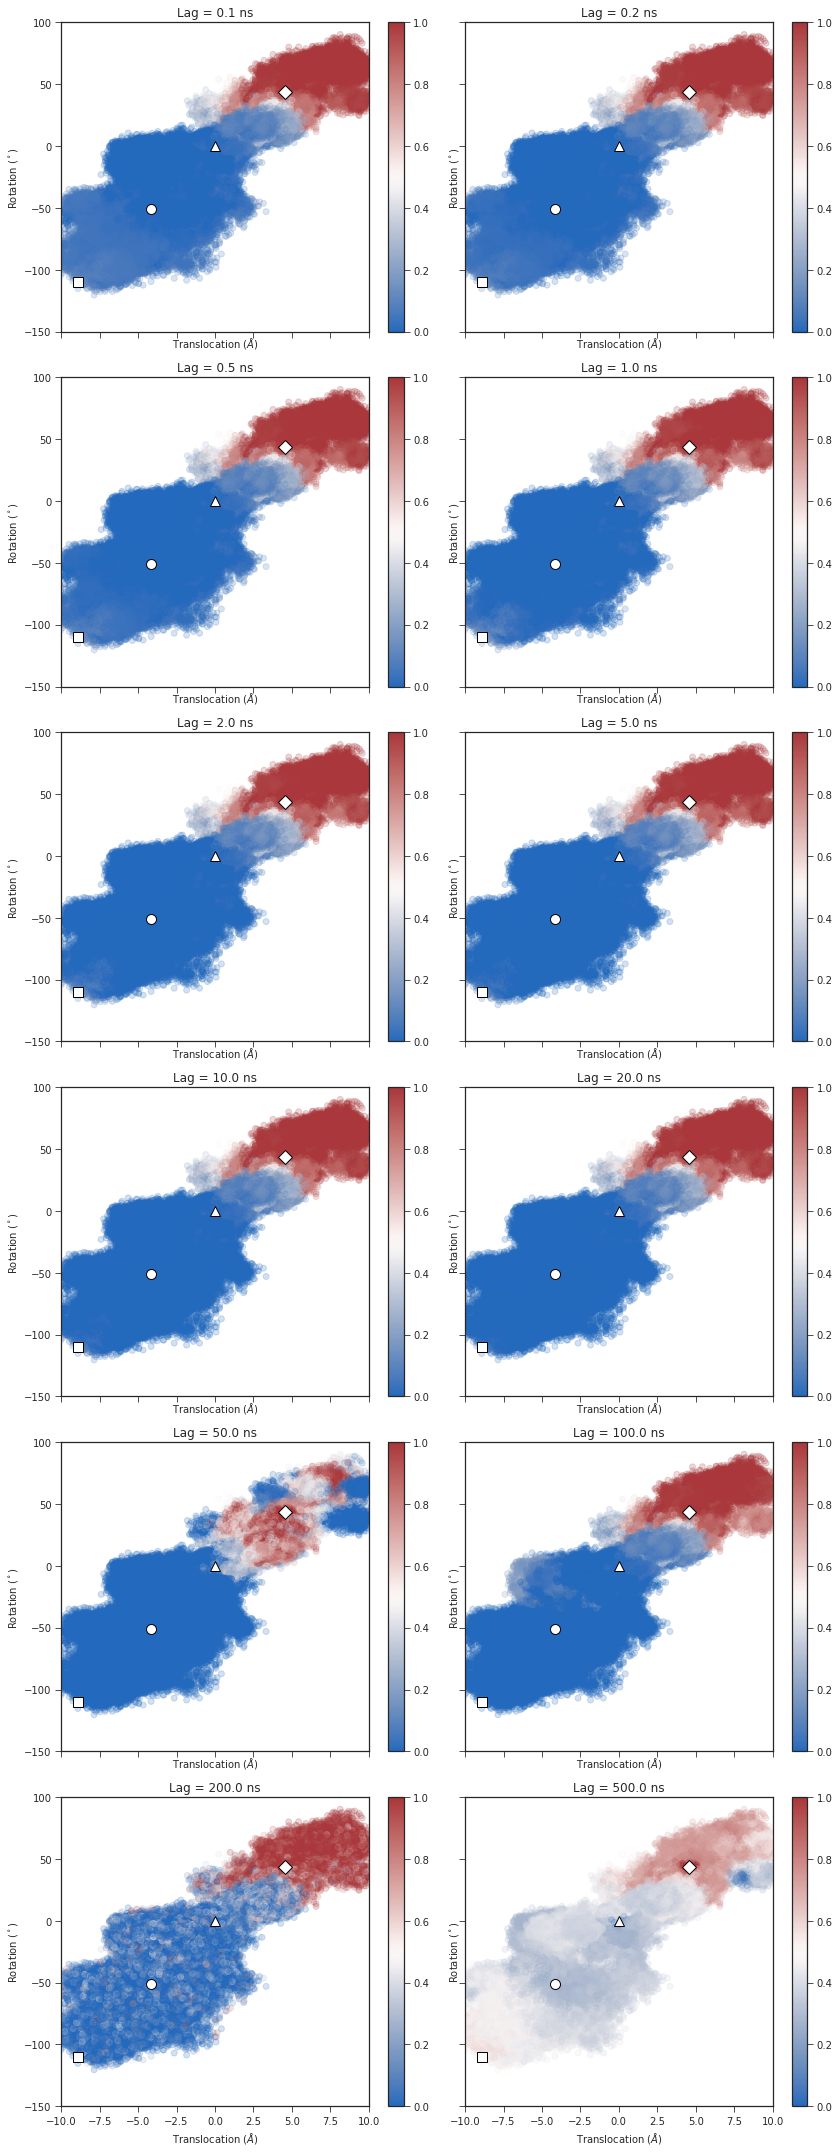

In [51]:
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cvs[::10].T, c=q_arr[::10], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()